<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_super2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fb042f41e20>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_super_ii.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


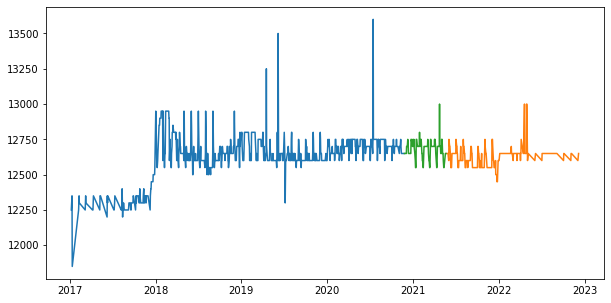

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [35]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_super2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [11]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 46ms/step - loss: 0.2135 - mae: 0.4594 - mape: 94.5857 - val_loss: 0.0795 - val_mae: 0.2377 - val_mape: 6610859.5000
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1543 - mae: 0.3900 - mape: 80.2120 - val_loss: 0.0560 - val_mae: 0.1914 - val_mape: 13194109.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1115 - mae: 0.3308 - mape: 67.9469 - val_loss: 0.0411 - val_mae: 0.1545 - val_mape: 19074006.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0801 - mae: 0.2794 - mape: 57.3208 - val_loss: 0.0331 - val_mae: 0.1234 - val_mape: 24135722.0000
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0574 - mae: 0.2354 - mape: 48.2018 - val_loss: 0.0296 - val_mae: 0.1179 - val_mape: 28485182.0000
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0410 - mae: 0.1978 - mape: 40.4227 - val_loss: 0.0293 - val_

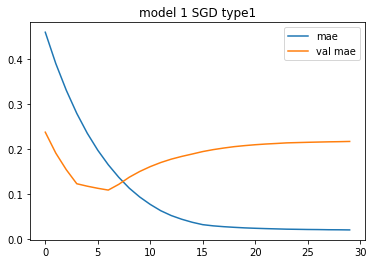

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
84.785225 0.6727918 101.31007091474174


,date,actual,prediction
0,2021-05-20,12650,12697.420898
1,2021-05-21,12650,12697.346680
2,2021-05-24,12650,12697.215820
3,2021-05-25,12650,12697.130859
4,2021-05-27,12650,12697.016602
...,...,...,...
229,2022-11-02,12650,12696.611328
230,2022-11-03,12650,12696.491211
231,2022-11-04,12650,12696.404297
232,2022-12-01,12600,12696.290039


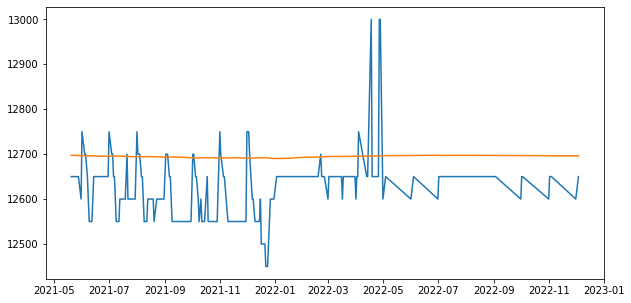

In [15]:
prediction = forecast_predict(model, test_beras_super2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras_super2 = pd.DataFrame()
data_new_beras_super2['date'] = y_test
data_new_beras_super2['actual'] = x_test
data_new_beras_super2['prediction'] = data_result
data_new_beras_super2.to_csv('beras_super2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras_super2.date, data_new_beras_super2.actual)
plt.plot(data_new_beras_super2.date, data_new_beras_super2.prediction)
data_new_beras_super2

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0429 - mape: 8.9043 - val_loss: 0.0622 - val_mae: 0.2105 - val_mape: 50555036.0000
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0035 - mae: 0.0426 - mape: 8.7903 - val_loss: 0.0616 - val_mae: 0.2091 - val_mape: 50393288.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0427 - mape: 8.8035 - val_loss: 0.0616 - val_mae: 0.2089 - val_mape: 50374924.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0426 - mape: 8.8089 - val_loss: 0.0617 - val_mae: 0.2092 - val_mape: 50408256.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0426 - mape: 8.7885 - val_loss: 0.0617 - val_mae: 0.2092 - val_mape: 50408196.0000
Epoch 6/30
718/718 [==============================] - 9s 12ms/step - loss: 0.0035 - mae: 0.0426 - mape: 8.7878 - val_loss: 0.0620 - val

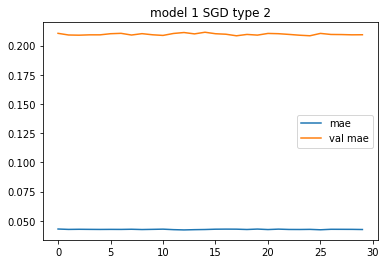

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
73.07612 0.5797494 91.04966772145575


,date,actual,prediction
0,2021-05-20,12650,12697.420898
1,2021-05-21,12650,12697.346680
2,2021-05-24,12650,12697.215820
3,2021-05-25,12650,12697.130859
4,2021-05-27,12650,12697.016602
...,...,...,...
229,2022-11-02,12650,12696.611328
230,2022-11-03,12650,12696.491211
231,2022-11-04,12650,12696.404297
232,2022-12-01,12600,12696.290039


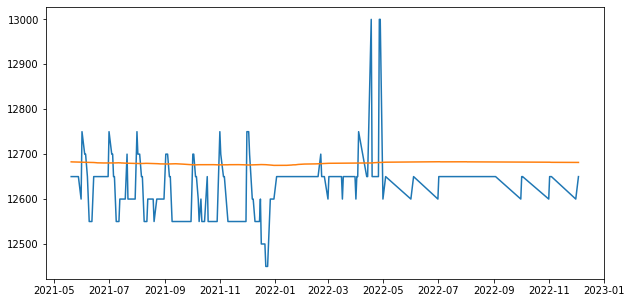

In [18]:
win_size1 = 60
test_beras_super2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_super2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_super2_1 = pd.DataFrame()
data_new_beras_super2_1['actual'] = x_test
data_new_beras_super2_1['prediction'] = data_result_1
data_new_beras_super2_1.to_csv('beras_super2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super2_1.actual)
plt.plot(y_test, data_new_beras_super2_1.prediction)
data_new_beras_super2

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0027 - mae: 0.0333 - mape: 7.0059 - val_loss: 0.0611 - val_mae: 0.2078 - val_mape: 50249976.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0027 - mae: 0.0332 - mape: 6.9624 - val_loss: 0.0605 - val_mae: 0.2059 - val_mape: 50042440.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0027 - mae: 0.0330 - mape: 6.8978 - val_loss: 0.0601 - val_mae: 0.2050 - val_mape: 49939712.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0027 - mae: 0.0329 - mape: 6.8573 - val_loss: 0.0598 - val_mae: 0.2043 - val_mape: 49852460.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0027 - mae: 0.0329 - mape: 6.8466 - val_loss: 0.0598 - val_mae: 0.2041 - val_mape: 49825392.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0027 - mae: 0.0329 - mape: 6.8349 - val_loss: 0.0596 - val_mae: 0

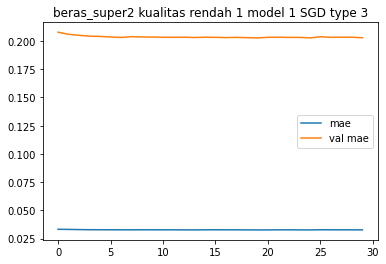

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras_super2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
64.90453 0.5148181 84.77600886859148


,actual,prediction
0,12650,12672.406250
1,12650,12672.253906
2,12650,12672.158203
3,12650,12671.998047
4,12650,12671.914062
...,...,...
229,12650,12671.633789
230,12650,12671.242188
231,12650,12671.377930
232,12600,12670.993164


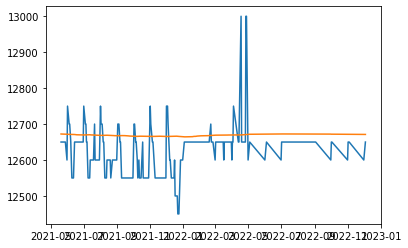

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_super2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_super2_2 = pd.DataFrame()
# data_new_beras_super21['date'] = date_test
data_new_beras_super2_2['actual'] = x_test
data_new_beras_super2_2['prediction'] = data_result_2
data_new_beras_super2_2.to_csv('beras_super2_model1_sgd_type3')

plt.plot(y_test, data_new_beras_super2_2.actual)
plt.plot(y_test, data_new_beras_super2_2.prediction)
data_new_beras_super2_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 39ms/step - loss: 0.1287 - mae: 0.3521 - mape: 72.3308 - val_loss: 0.0421 - val_mae: 0.1563 - val_mape: 19174188.0000
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0220 - mae: 0.1226 - mape: 25.0023 - val_loss: 0.0370 - val_mae: 0.1341 - val_mape: 40298124.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0019 - mae: 0.0229 - mape: 4.6471 - val_loss: 0.0353 - val_mae: 0.1258 - val_mape: 39067176.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0018 - mae: 0.0217 - mape: 4.3079 - val_loss: 0.0356 - val_mae: 0.1276 - val_mape: 39327324.0000
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0019 - mae: 0.0225 - mape: 4.4604 - val_loss: 0.0356 - val_mae: 0.1273 - val_mape: 39291560.0000
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0018 - mae: 0.0217 - mape: 4.2752 - val_loss: 0.0363 - val_mae:

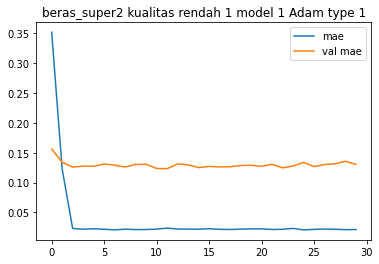

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras_super2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
56.64618 0.44890675 75.23853019418475


,actual,prediction
0,12650,12690.309570
1,12650,12689.188477
2,12650,12688.595703
3,12650,12687.537109
4,12650,12686.930664
...,...,...
229,12650,12677.669922
230,12650,12674.539062
231,12650,12676.387695
232,12600,12673.570312


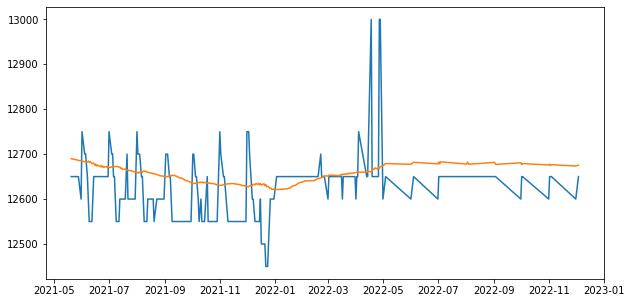

In [25]:
prediction_a = forecast_predict(model_a, test_beras_super2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_super2_a = pd.DataFrame()
# data_new_beras_super21['date'] = date_test
data_new_beras_super2_a['actual'] = x_test
data_new_beras_super2_a['prediction'] = data_result_a
data_new_beras_super2_a.to_csv('beras_super2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_super2_a.actual)
plt.plot(y_test, data_new_beras_super2_a.prediction)
data_new_beras_super2_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0039 - mae: 0.0414 - mape: 8.4483 - val_loss: 0.0400 - val_mae: 0.1459 - val_mape: 42032576.0000
Epoch 2/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0036 - mae: 0.0400 - mape: 8.1910 - val_loss: 0.0423 - val_mae: 0.1540 - val_mape: 43225052.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0036 - mae: 0.0397 - mape: 8.1378 - val_loss: 0.0405 - val_mae: 0.1479 - val_mape: 42303412.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0395 - mape: 8.0798 - val_loss: 0.0428 - val_mae: 0.1557 - val_mape: 43454444.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0403 - mape: 8.2401 - val_loss: 0.0454 - val_mae: 0.1636 - val_mape: 44623176.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0035 - mae: 0.0396 - mape: 8.1105 - val_loss: 0.0429 - val_

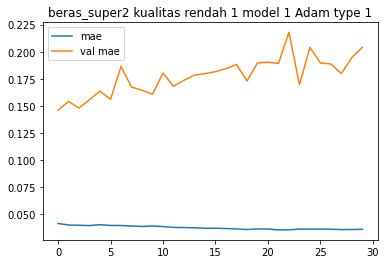

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras_super2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
98.488464 0.78139335 110.951671630039


,actual,prediction
0,12650,12733.078125
1,12650,12730.965820
2,12650,12730.551758
3,12650,12728.679688
4,12650,12728.252930
...,...,...
229,12650,12728.582031
230,12650,12723.445312
231,12650,12725.587891
232,12600,12721.408203


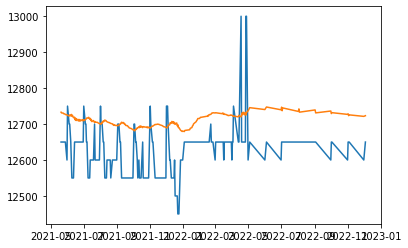

In [28]:
prediction_a1 = forecast_predict(model_a, test_beras_super2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_super2_a1 = pd.DataFrame()
data_new_beras_super2_a1['actual'] = x_test
data_new_beras_super2_a1['prediction'] = data_result_a1
data_new_beras_super2_a1.to_csv('beras_super2_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_super2_a1.actual)
plt.plot(y_test, data_new_beras_super2_a1.prediction)
data_new_beras_super2_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0026 - mae: 0.0293 - mape: 6.0784 - val_loss: 0.0568 - val_mae: 0.1929 - val_mape: 48847552.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0274 - mape: 5.6516 - val_loss: 0.0555 - val_mae: 0.1895 - val_mape: 48412340.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0274 - mape: 5.6341 - val_loss: 0.0567 - val_mae: 0.1927 - val_mape: 48828444.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0279 - mape: 5.7621 - val_loss: 0.0551 - val_mae: 0.1884 - val_mape: 48287268.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0275 - mape: 5.6449 - val_loss: 0.0557 - val_mae: 0.1898 - val_mape: 48475920.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0274 - mape: 5.6357 - val_loss: 0.0556 - val_mae: 0

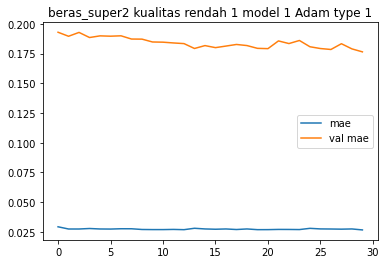

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras_super2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
46.541924 0.36832568 67.50405080437766


,actual,prediction
0,12650,12662.982422
1,12650,12660.686523
2,12650,12660.288086
3,12650,12658.180664
4,12650,12657.740234
...,...,...
229,12650,12660.332031
230,12650,12654.804688
231,12650,12657.301758
232,12600,12652.689453


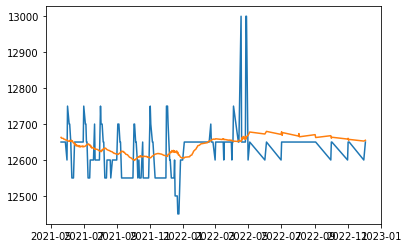

In [31]:
prediction_a2 = forecast_predict(model_a, test_beras_super2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_super2_a2 = pd.DataFrame()
# data_new_beras_super21['date'] = date_test
data_new_beras_super2_a2['actual'] = x_test
data_new_beras_super2_a2['prediction'] = data_result_a2
data_new_beras_super2_a2.to_csv('beras_super2_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_super2_a2.actual)
plt.plot(y_test, data_new_beras_super2_a2.prediction)
data_new_beras_super2_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.1363 - mae: 0.3505 - mape: 72.1337 - val_loss: 0.0300 - val_mae: 0.1163 - val_mape: 32448568.0000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0038 - mae: 0.0409 - mape: 8.3299 - val_loss: 0.0341 - val_mae: 0.1207 - val_mape: 38308800.0000
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0018 - mae: 0.0213 - mape: 4.2046 - val_loss: 0.0344 - val_mae: 0.1223 - val_mape: 38552104.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0018 - mae: 0.0207 - mape: 4.1091 - val_loss: 0.0337 - val_mae: 0.1184 - val_mape: 37963088.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0018 - mae: 0.0223 - mape: 4.4337 - val_loss: 0.0325 - val_mae: 0.1121 - val_mape: 36813776.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0019 - mae: 0.0224 - mape: 4.4342 - val_loss: 0.0333 - val_mae: 

17/17 [==============================] - 0s 7ms/step - loss: 0.0171 - mae: 0.0738 - mape: 17.8997


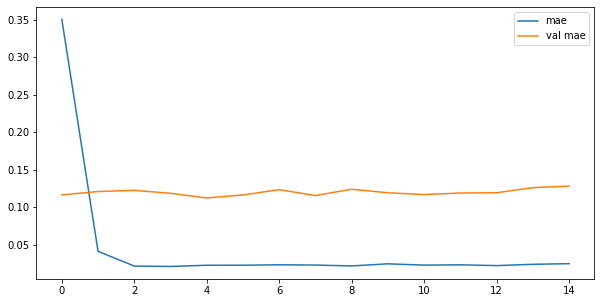

In [36]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [37]:
prediction1 = forecast_predict(model1, test_beras_super2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras_super21 = pd.DataFrame()
data_new_beras_super21['actual'] = x_test
data_new_beras_super21['prediction'] = data_result1
data_new_beras_super21.to_csv('beras_super2_model2_adam_type1.csv')

data_new_beras_super21

131/131 [==============================] - 2s 8ms/step
145.8008 1.1569238 156.20523733817313


,actual,prediction
0,12650,12772.893555
1,12650,12772.745117
2,12650,12772.496094
3,12650,12772.318359
4,12650,12772.065430
...,...,...
229,12650,12768.769531
230,12650,12768.580078
231,12650,12768.536133
232,12600,12768.337891


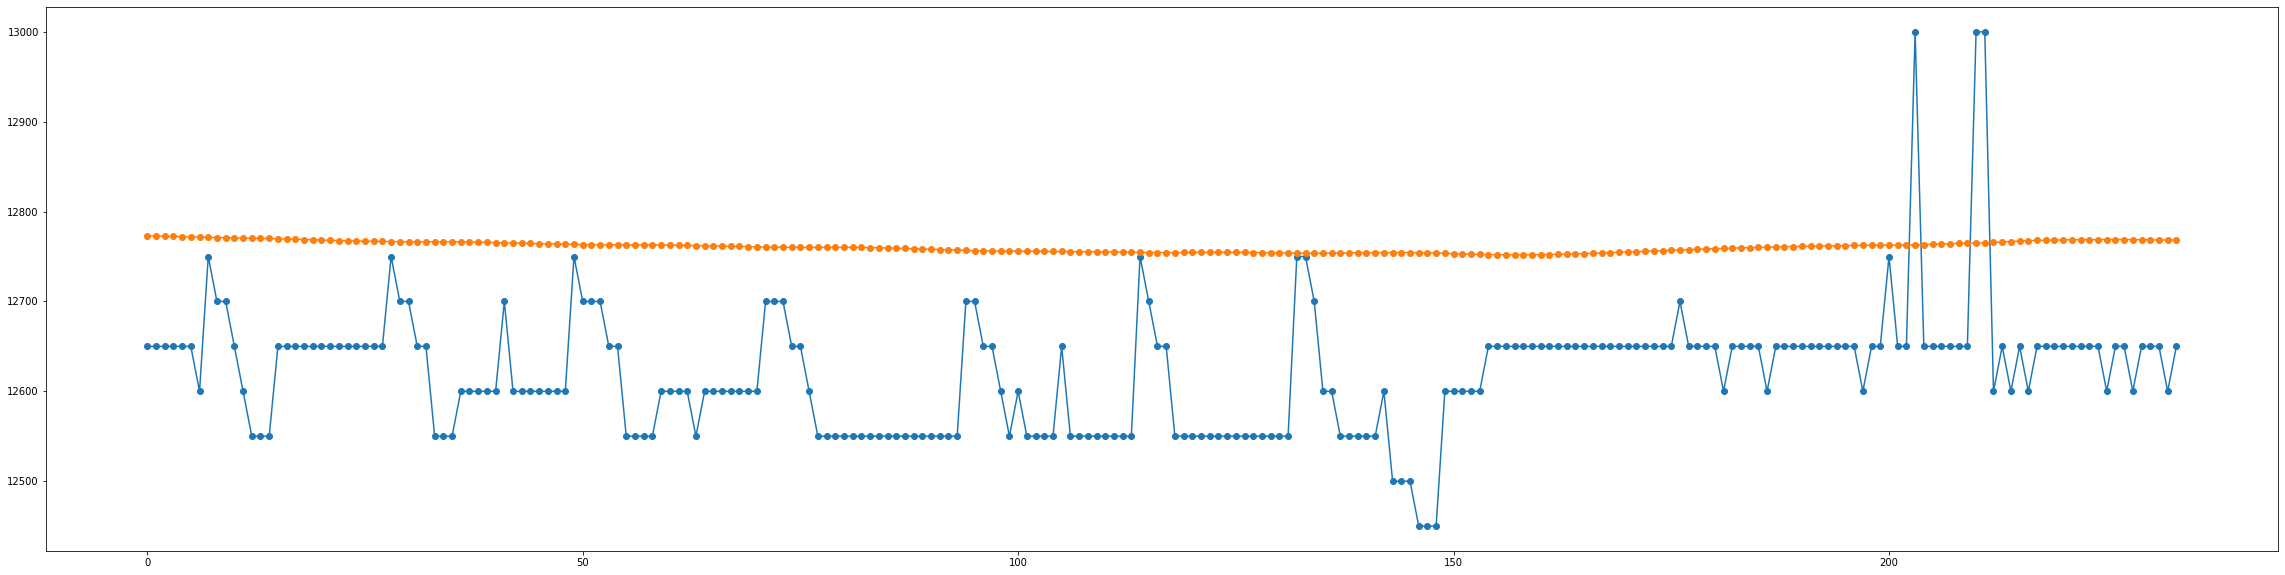

In [38]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras_super21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras_super21['prediction'], '-o')

#### Type 2

In [39]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0042 - mae: 0.0437 - mape: 8.9609 - val_loss: 0.0391 - val_mae: 0.1431 - val_mape: 41696640.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0413 - mape: 8.4370 - val_loss: 0.0433 - val_mae: 0.1576 - val_mape: 43836996.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0397 - mape: 8.1207 - val_loss: 0.0443 - val_mae: 0.1606 - val_mape: 44296328.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0035 - mae: 0.0395 - mape: 8.0914 - val_loss: 0.0481 - val_mae: 0.1716 - val_mape: 45933804.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0035 - mae: 0.0395 - mape: 8.1012 - val_loss: 0.0488 - val_mae: 0.1734 - val_mape: 46180004.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0034 - mae: 0.0396 - mape: 8.1147 - val_loss: 0.0493 - val_

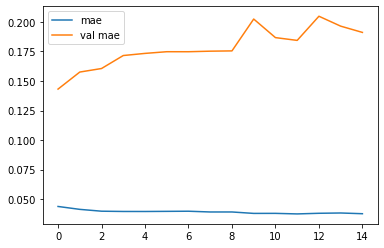

In [40]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
148.0759 1.1749812 156.20523733817313


,actual,prediction
0,12650,12769.086914
1,12650,12768.931641
2,12650,12768.769531
3,12650,12768.588867
4,12650,12768.431641
...,...,...
229,12650,12769.037109
230,12650,12768.373047
231,12650,12768.481445
232,12600,12767.918945


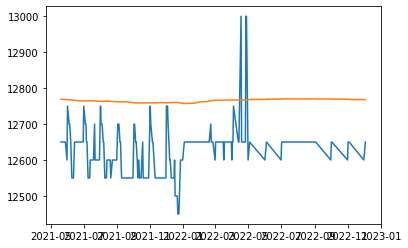

In [41]:
prediction1_1 = forecast_predict(model1, test_beras_super2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras_super21_1 = pd.DataFrame()
data_new_beras_super21_1['actual'] = x_test
data_new_beras_super21_1['prediction'] = data_result1_1
data_new_beras_super21_1.to_csv('beras_super2_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras_super21_1.actual)
plt.plot(y_test, data_new_beras_super21_1.prediction)
data_new_beras_super21_1

#### Type 3

In [42]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0026 - mae: 0.0290 - mape: 6.0041 - val_loss: 0.0567 - val_mae: 0.1933 - val_mape: 49073164.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0026 - mae: 0.0289 - mape: 5.9754 - val_loss: 0.0553 - val_mae: 0.1896 - val_mape: 48590668.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0288 - mape: 5.9315 - val_loss: 0.0567 - val_mae: 0.1932 - val_mape: 49053440.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0286 - mape: 5.9035 - val_loss: 0.0559 - val_mae: 0.1912 - val_mape: 48790896.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0284 - mape: 5.8785 - val_loss: 0.0545 - val_mae: 0.1877 - val_mape: 48326660.0000
Epoch 6/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0025 - mae: 0.0290 - mape: 5.9975 - val_loss: 0.0550 - val_mae: 0

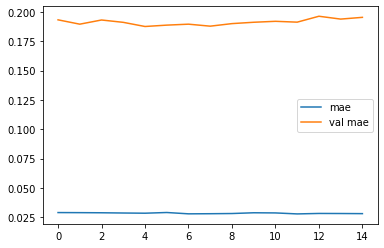

In [43]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
139.3347 1.1056477 156.20523733817313


,actual,prediction
0,12650,12762.331055
1,12650,12762.116211
2,12650,12761.899414
3,12650,12761.662109
4,12650,12761.431641
...,...,...
229,12650,12761.970703
230,12650,12761.311523
231,12650,12761.397461
232,12600,12760.833008


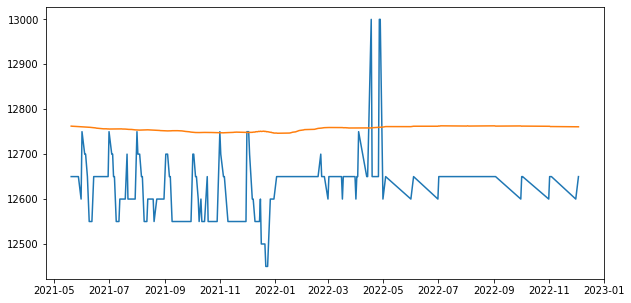

In [44]:
prediction1_2 = forecast_predict(model1, test_beras_super2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras_super21_2 = pd.DataFrame()
data_new_beras_super21_2['actual'] = x_test
data_new_beras_super21_2['prediction'] = data_result1_2
data_new_beras_super21_2.to_csv('beras_super2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super21_2.actual)
plt.plot(y_test, data_new_beras_super21_2.prediction)

data_new_beras_super21_2

### SGD

In [45]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [46]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [47]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 48ms/step - loss: 0.1979 - mae: 0.4419 - mape: 90.9266 - val_loss: 0.0709 - val_mae: 0.2220 - val_mape: 8803259.0000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1307 - mae: 0.3581 - mape: 73.5936 - val_loss: 0.0462 - val_mae: 0.1691 - val_mape: 16803884.0000
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0853 - mae: 0.2883 - mape: 59.1560 - val_loss: 0.0338 - val_mae: 0.1269 - val_mape: 23569224.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0547 - mae: 0.2294 - mape: 46.9669 - val_loss: 0.0295 - val_mae: 0.1175 - val_mape: 29141394.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0347 - mae: 0.1808 - mape: 36.8995 - val_loss: 0.0299 - val_mae: 0.1119 - val_mape: 33697744.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0218 - mae: 0.1413 - mape: 28.7356 - val_loss: 0.0327 - val_m

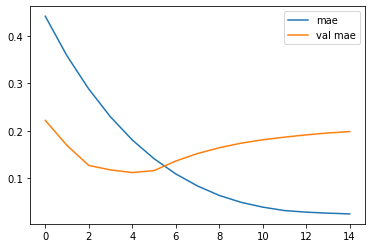

In [48]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
147.10757 1.1673255 157.79688660387126


,actual,prediction
0,12650,12764.125977
1,12650,12764.099609
2,12650,12764.000000
3,12650,12763.972656
4,12650,12763.876953
...,...,...
229,12650,12763.453125
230,12650,12763.628906
231,12650,12763.343750
232,12600,12763.520508


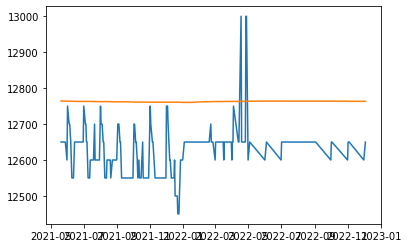

In [49]:
prediction1_a = forecast_predict(model1_a, test_beras_super2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras_super21_a = pd.DataFrame()
data_new_beras_super21_a['actual'] = x_test
data_new_beras_super21_a['prediction'] = data_result1_a
data_new_beras_super21_a.to_csv('beras_super2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras_super21_a.actual)
plt.plot(y_test, data_new_beras_super21_a.prediction)

data_new_beras_super21_a

#### Type 2


In [50]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0034 - mae: 0.0418 - mape: 8.6094 - val_loss: 0.0580 - val_mae: 0.1989 - val_mape: 49323900.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0034 - mae: 0.0417 - mape: 8.5763 - val_loss: 0.0584 - val_mae: 0.2000 - val_mape: 49443964.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0034 - mae: 0.0420 - mape: 8.6567 - val_loss: 0.0588 - val_mae: 0.2012 - val_mape: 49584236.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0034 - mae: 0.0417 - mape: 8.6128 - val_loss: 0.0588 - val_mae: 0.2011 - val_mape: 49572928.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0034 - mae: 0.0419 - mape: 8.6614 - val_loss: 0.0577 - val_mae: 0.1980 - val_mape: 49220880.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0034 - mae: 0.0415 - mape: 8.5528 - val_loss: 0.0586 - val_

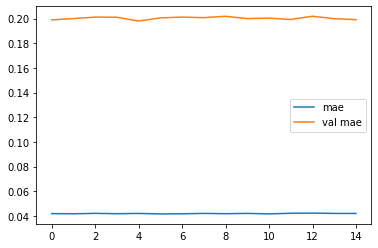

In [51]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
147.05412 1.1669012 157.74239779621712


,actual,prediction
0,12650,12764.094727
1,12650,12764.078125
2,12650,12763.953125
3,12650,12763.936523
4,12650,12763.820312
...,...,...
229,12650,12763.477539
230,12650,12763.668945
231,12650,12763.333008
232,12600,12763.535156


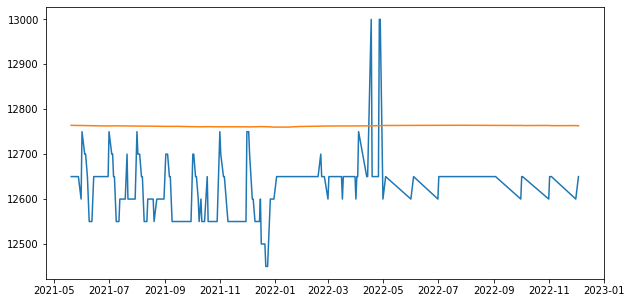

In [52]:
prediction1_a1 = forecast_predict(model1_a, test_beras_super2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras_super21_a1 = pd.DataFrame()
data_new_beras_super21_a1['actual'] = x_test
data_new_beras_super21_a1['prediction'] = data_result1_a1
data_new_beras_super21_a1.to_csv('beras_super2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super21_a1.actual)
plt.plot(y_test, data_new_beras_super21_a1.prediction)
data_new_beras_super21_a1

#### Type 3

In [53]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0027 - mae: 0.0326 - mape: 6.8616 - val_loss: 0.0576 - val_mae: 0.1977 - val_mape: 49192488.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0027 - mae: 0.0325 - mape: 6.7930 - val_loss: 0.0567 - val_mae: 0.1954 - val_mape: 48929452.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0026 - mae: 0.0323 - mape: 6.7315 - val_loss: 0.0565 - val_mae: 0.1946 - val_mape: 48834656.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0026 - mae: 0.0321 - mape: 6.6832 - val_loss: 0.0562 - val_mae: 0.1940 - val_mape: 48764300.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0026 - mae: 0.0322 - mape: 6.6861 - val_loss: 0.0562 - val_mae: 0.1938 - val_mape: 48743540.0000
Epoch 6/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0026 - mae: 0.0321 - mape: 6.6810 - val_loss: 0.0560 - val_mae: 0

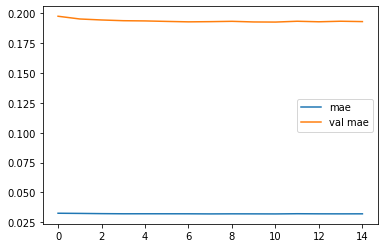

In [54]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
144.80197 1.1490428 155.68099519731047


,actual,prediction
0,12650,12761.797852
1,12650,12761.781250
2,12650,12761.658203
3,12650,12761.641602
4,12650,12761.523438
...,...,...
229,12650,12761.148438
230,12650,12761.339844
231,12650,12761.006836
232,12600,12761.208008


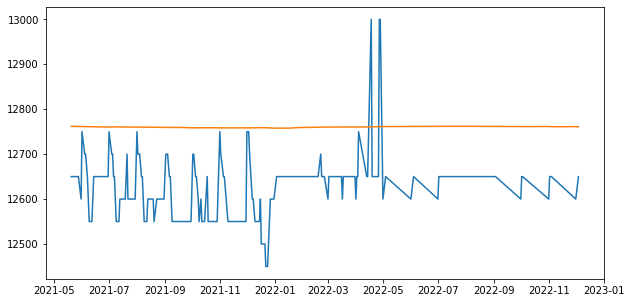

In [55]:
prediction1_a2 = forecast_predict(model1_a, test_beras_super2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras_super21_a2 = pd.DataFrame()
data_new_beras_super21_a2['actual'] = x_test
data_new_beras_super21_a2['prediction'] = data_result1_a2
data_new_beras_super21_a2.to_csv('beras_super2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super21_a2.actual)
plt.plot(y_test, data_new_beras_super21_a2.prediction)

data_new_beras_super21_a2

## model 2

### SGD

In [56]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [57]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [58]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.2143 - mae: 0.4605 - mape: 94.8027 - val_loss: 0.0798 - val_mae: 0.2383 - val_mape: 6502222.0000
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1567 - mae: 0.3930 - mape: 80.8251 - val_loss: 0.0558 - val_mae: 0.1909 - val_mape: 13217708.0000
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.1137 - mae: 0.3342 - mape: 68.6751 - val_loss: 0.0412 - val_mae: 0.1548 - val_mape: 19002920.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0827 - mae: 0.2838 - mape: 58.2178 - val_loss: 0.0331 - val_mae: 0.1235 - val_mape: 24031498.0000
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0598 - mae: 0.2407 - mape: 49.3288 - val_loss: 0.0297 - val_mae: 0.1181 - val_mape: 28319852.0000
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0432 - mae: 0.2032 - mape: 41.5493 - val_loss: 0.0292 - val_m

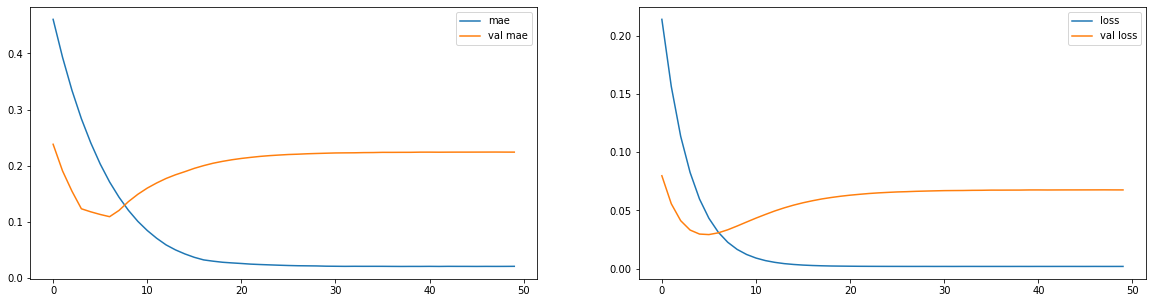

In [59]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
153.19553 1.2156067 163.50237718073092


,actual,prediction
0,12650,12768.949219
1,12650,12768.890625
2,12650,12768.878906
3,12650,12768.873047
4,12650,12768.914062
...,...,...
229,12650,12768.833008
230,12650,12768.851562
231,12650,12768.776367
232,12600,12768.796875


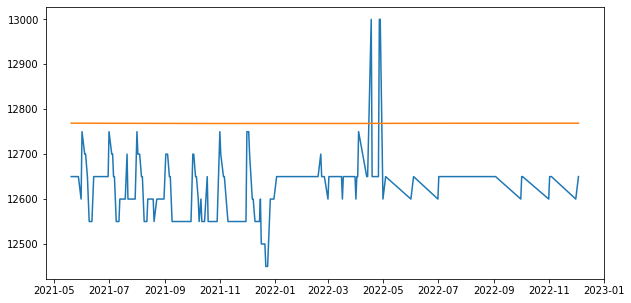

In [60]:
prediction2 = forecast_predict(model2, test_beras_super2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras_super22 = pd.DataFrame()
data_new_beras_super22['actual'] = x_test
data_new_beras_super22['prediction'] = data_result2
data_new_beras_super22.to_csv('beras_super2_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_super22.actual)
plt.plot(y_test, data_new_beras_super22.prediction)
data_new_beras_super22

#### Type2

In [61]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0035 - mae: 0.0436 - mape: 9.0660 - val_loss: 0.0642 - val_mae: 0.2158 - val_mape: 51141056.0000
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0035 - mae: 0.0431 - mape: 8.9015 - val_loss: 0.0643 - val_mae: 0.2160 - val_mape: 51155392.0000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0035 - mae: 0.0434 - mape: 8.9734 - val_loss: 0.0641 - val_mae: 0.2156 - val_mape: 51107088.0000
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0035 - mae: 0.0432 - mape: 8.9094 - val_loss: 0.0644 - val_mae: 0.2164 - val_mape: 51198004.0000
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0035 - mae: 0.0433 - mape: 8.9604 - val_loss: 0.0642 - val_mae: 0.2158 - val_mape: 51131960.0000
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0035 - mae: 0.0432 - mape: 8.9105 - val_loss: 0.0645 - val_

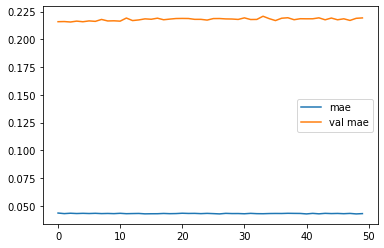

In [62]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [63]:
prediction2_1 = forecast_predict(model2, test_beras_super2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras_super22_1 = pd.DataFrame()
data_new_beras_super22_1['actual'] = x_test
data_new_beras_super22_1['prediction'] = data_result2_1
data_new_beras_super22_1.to_csv('beras_super2_model3_sgd_type2.csv')

data_new_beras_super22

199/199 [==============================] - 1s 3ms/step
149.41684 1.1856451 160.03235756793063


,actual,prediction
0,12650,12768.949219
1,12650,12768.890625
2,12650,12768.878906
3,12650,12768.873047
4,12650,12768.914062
...,...,...
229,12650,12768.833008
230,12650,12768.851562
231,12650,12768.776367
232,12600,12768.796875


#### Type 3

In [64]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0028 - mae: 0.0341 - mape: 7.1911 - val_loss: 0.0648 - val_mae: 0.2174 - val_mape: 51297724.0000
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0027 - mae: 0.0338 - mape: 7.0964 - val_loss: 0.0643 - val_mae: 0.2161 - val_mape: 51152268.0000
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0027 - mae: 0.0337 - mape: 7.0552 - val_loss: 0.0638 - val_mae: 0.2149 - val_mape: 51015152.0000
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0027 - mae: 0.0336 - mape: 7.0188 - val_loss: 0.0635 - val_mae: 0.2142 - val_mape: 50927276.0000
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0027 - mae: 0.0337 - mape: 7.0281 - val_loss: 0.0633 - val_mae: 0.2136 - val_mape: 50858468.0000
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0027 - mae: 0.0335 - mape: 6.9870 - val_loss: 0.0632 - val_mae: 0

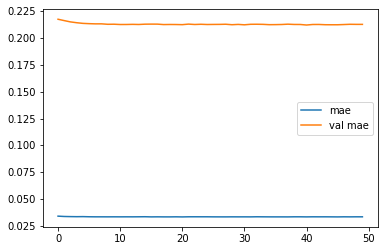

In [65]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [66]:
prediction2_2 = forecast_predict(model2, test_beras_super2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras_super22_2 = pd.DataFrame()
data_new_beras_super22_2['actual'] = x_test
data_new_beras_super22_2['prediction'] = data_result2_2
data_new_beras_super22_2.to_csv('beras_super2_model3_sgd-type3.csv')

data_new_beras_super22_2

181/181 [==============================] - 1s 4ms/step
146.22372 1.160325 157.10261127285568


,actual,prediction
0,12650,12761.328125
1,12650,12761.345703
2,12650,12761.338867
3,12650,12761.332031
4,12650,12761.313477
...,...,...
229,12650,12761.353516
230,12650,12761.368164
231,12650,12761.387695
232,12600,12761.353516


### Adam

In [67]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [68]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.1920 - mae: 0.4346 - mape: 89.4586 - val_loss: 0.0660 - val_mae: 0.2121 - val_mape: 10203284.0000
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0517 - mae: 0.1873 - mape: 38.3534 - val_loss: 0.0295 - val_mae: 0.1175 - val_mape: 30536084.0000
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0308 - mape: 6.1476 - val_loss: 0.0295 - val_mae: 0.1177 - val_mape: 30284606.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0020 - mae: 0.0264 - mape: 5.2651 - val_loss: 0.0295 - val_mae: 0.1173 - val_mape: 30649780.0000
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0022 - mae: 0.0266 - mape: 5.3125 - val_loss: 0.0295 - val_mae: 0.1173 - val_mape: 30659334.0000
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0022 - mae: 0.0276 - mape: 5.4745 - val_loss: 0.0295 - val_mae:

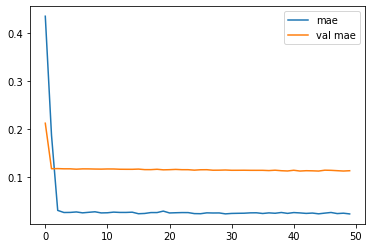

In [69]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [70]:
prediction2_a = forecast_predict(model2_a, test_beras_super2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras_super22_a = pd.DataFrame()
data_new_beras_super22_a['actual'] = x_test
data_new_beras_super22_a['prediction'] = data_result2_a
data_new_beras_super22_a.to_csv('beras_super2_model3_adam-type1.csv')

data_new_beras_super22_a

131/131 [==============================] - 1s 6ms/step
143.78816 1.1409891 154.7859787537295


,actual,prediction
0,12650,12766.628906
1,12650,12767.546875
2,12650,12766.820312
3,12650,12767.018555
4,12650,12766.251953
...,...,...
229,12650,12759.950195
230,12650,12759.001953
231,12650,12759.987305
232,12600,12760.007812


#### Type 2

In [71]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0046 - mae: 0.0448 - mape: 9.1596 - val_loss: 0.0406 - val_mae: 0.1498 - val_mape: 42472780.0000
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0040 - mae: 0.0431 - mape: 8.8246 - val_loss: 0.0445 - val_mae: 0.1626 - val_mape: 44332788.0000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0040 - mae: 0.0431 - mape: 8.8237 - val_loss: 0.0496 - val_mae: 0.1767 - val_mape: 46395168.0000
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0038 - mae: 0.0417 - mape: 8.5526 - val_loss: 0.0499 - val_mae: 0.1774 - val_mape: 46478788.0000
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0038 - mae: 0.0430 - mape: 8.8386 - val_loss: 0.0516 - val_mae: 0.1818 - val_mape: 47103668.0000
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0037 - mae: 0.0417 - mape: 8.5683 - val_loss: 0.0486 - val_

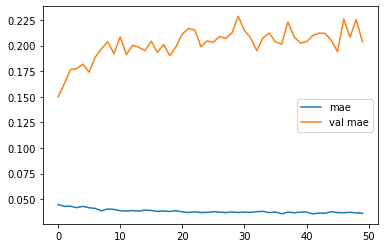

In [72]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
146.30116 1.1609173 156.85295537341653


,actual,prediction
0,12650,12764.849609
1,12650,12764.758789
2,12650,12765.071289
3,12650,12764.749023
4,12650,12764.890625
...,...,...
229,12650,12767.757812
230,12650,12766.247070
231,12650,12767.862305
232,12600,12767.322266


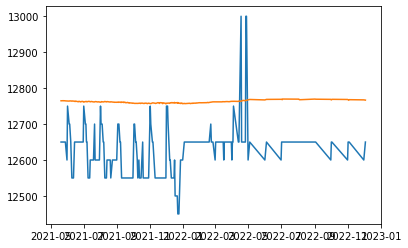

In [73]:
prediction2_a1 = forecast_predict(model2_a, test_beras_super2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras_super22_a1 = pd.DataFrame()
data_new_beras_super22_a1['actual'] = x_test
data_new_beras_super22_a1['prediction'] = data_result2_a1
data_new_beras_super22_a1.to_csv('beras_super2_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras_super22_a1.actual)
plt.plot(y_test, data_new_beras_super22_a1.prediction)
data_new_beras_super22_a1

#### Type 3

In [74]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0026 - mae: 0.0300 - mape: 6.2328 - val_loss: 0.0545 - val_mae: 0.1885 - val_mape: 47815388.0000
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0026 - mae: 0.0288 - mape: 5.9594 - val_loss: 0.0536 - val_mae: 0.1862 - val_mape: 47508712.0000
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0025 - mae: 0.0286 - mape: 5.9329 - val_loss: 0.0526 - val_mae: 0.1839 - val_mape: 47185776.0000
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0025 - mae: 0.0282 - mape: 5.7643 - val_loss: 0.0543 - val_mae: 0.1878 - val_mape: 47756432.0000
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0026 - mae: 0.0290 - mape: 6.0392 - val_loss: 0.0527 - val_mae: 0.1839 - val_mape: 47218816.0000
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0025 - mae: 0.0282 - mape: 5.8297 - val_loss: 0.0501 - val_mae: 0

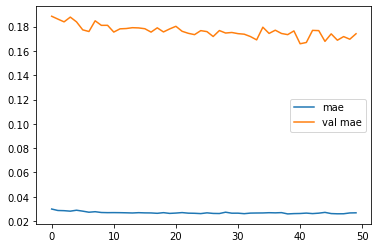

In [75]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
140.45493 1.1145313 151.0932684842379


,actual,prediction
0,12650,12760.882812
1,12650,12760.355469
2,12650,12759.966797
3,12650,12759.517578
4,12650,12759.881836
...,...,...
229,12650,12773.342773
230,12650,12772.085938
231,12650,12771.715820
232,12600,12769.788086


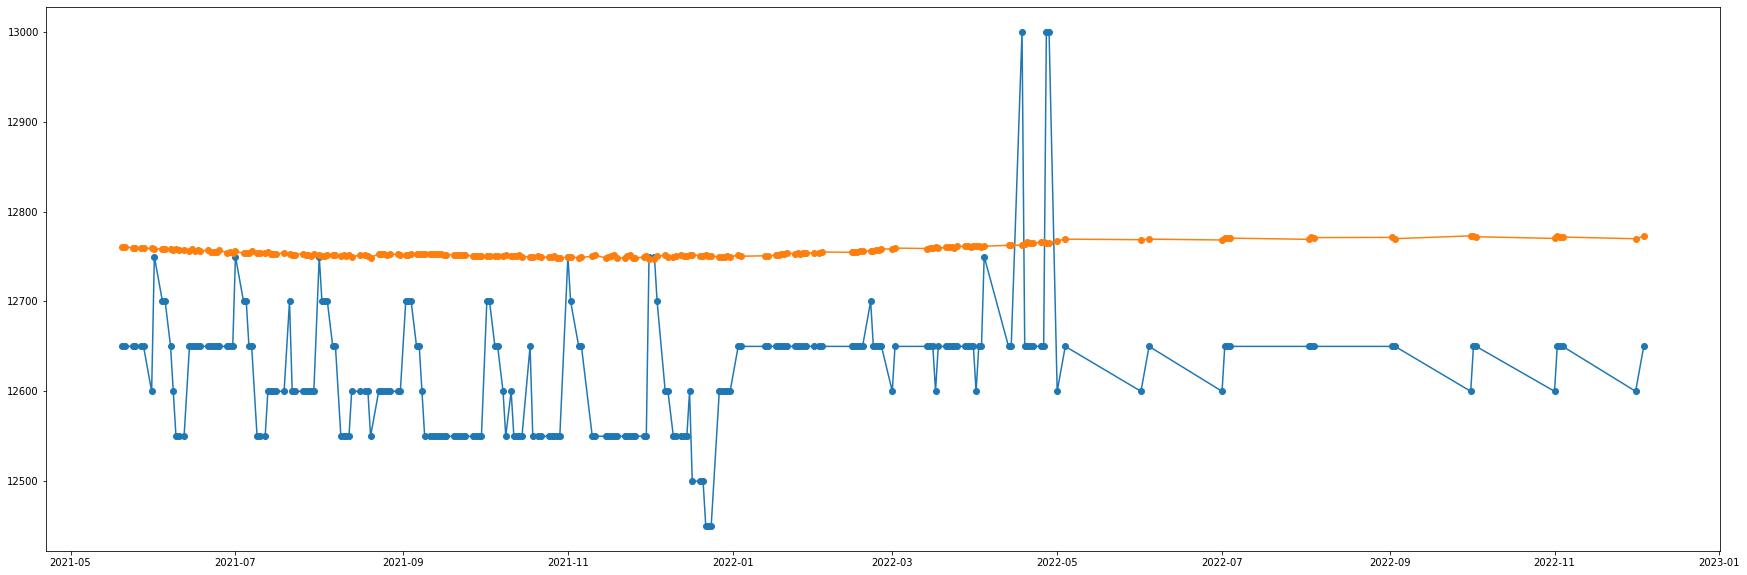

In [76]:
prediction2_a2 = forecast_predict(model2_a, test_beras_super2_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras_super22_a2 = pd.DataFrame()
data_new_beras_super22_a2['actual'] = x_test
data_new_beras_super22_a2['prediction'] = data_result2_a2
data_new_beras_super22_a2.to_csv('beras_super2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras_super22_a2.actual, '-o')
plt.plot(y_test,data_new_beras_super22_a2.prediction, '-o')
data_new_beras_super22_a2